In [23]:
import yfinance as yf
import pandas as pd 
import datetime as dt
import numpy as np
from scipy.optimize import minimize

In [24]:
tickers = ['SPY', 'NVDA','GLD','AAPL', 'MSFT']

In [25]:
import datetime  # Import the datetime module first

EndDate = datetime.datetime.today()  # Use datetime.datetime instead of datetime.dt

In [26]:
from datetime import timedelta  # Import the timedelta class from datetime module

StartDate = EndDate - timedelta(days = 365*3)
print(StartDate)

2022-07-23 15:01:05.111391


In [27]:
# Import pandas library first
import pandas as pd

# Now create the DataFrame
adj_close_df = pd.DataFrame()

In [28]:
tickers = ['SPY', 'NVDA','GLD','AAPL', 'MSFT']

# Create a DataFrame to store adjusted close prices
adj_close_df = pd.DataFrame()  # Assuming you've imported pandas as pd

# Loop through each ticker
for ticker in tickers:  # Changed variable name from 'tickers' to 'ticker'
    data = yf.download(ticker, start=StartDate, end=EndDate, auto_adjust=False)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [29]:
print(adj_close_df)

                   SPY        NVDA         GLD        AAPL        MSFT
Date                                                                  
2022-07-25  379.123169   16.999481  160.229996  150.534897  252.426895
2022-07-26  374.637848   16.509188  160.039993  149.206253  245.668320
2022-07-27  384.365784   17.764378  161.669998  154.314270  262.091766
2022-07-28  389.186646   17.958097  163.639999  154.865448  269.572021
2022-07-29  394.860474   18.136839  164.100006  159.943954  273.794861
...                ...         ...         ...         ...         ...
2025-07-15  622.140015  170.699997  306.730011  209.110001  505.820007
2025-07-16  624.219971  171.369995  308.260010  210.160004  505.619995
2025-07-17  628.039978  173.000000  307.589996  210.020004  511.700012
2025-07-18  627.580017  172.410004  308.390015  211.179993  510.049988
2025-07-21  628.770020  171.380005  313.130005  212.479996  510.059998

[750 rows x 5 columns]


In [30]:
log_returns= np.log(adj_close_df / adj_close_df.shift(1))

In [31]:
log_returns= log_returns.dropna()

In [32]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

           SPY      NVDA       GLD      AAPL      MSFT
SPY   0.029955  0.062691  0.004713  0.036509  0.033850
NVDA  0.062691  0.283640  0.008327  0.069245  0.083455
GLD   0.004713  0.008327  0.023869  0.004019  0.005161
AAPL  0.036509  0.069245  0.004019  0.078171  0.044528
MSFT  0.033850  0.083455  0.005161  0.044528  0.068384


In [33]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix@ weights
    return np.sqrt(variance)

In [34]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

In [35]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    returns(expected_return(weights, log_returns)- risk_free_rate)/standard_deviation(weights, cov_matrix)



In [36]:
!pip install fredapi

from fredapi import Fred
fred = Fred(api_key='307e8e5ac01fd809cbfe9ba2b4ec8e92')
ten_year_treasury_rate = fred.get_series_latest_release('GS10')/100

risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.0438


In [37]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return-sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)
    

In [38]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights)-1}
bounds = [(0, 0.4) for _ in range(len(tickers))]

In [39]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


In [40]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    # Assuming this is your function definition
    # Changed 'returns' to 'log_returns' in the function body
    portfolio_return = np.sum(log_returns.mean() * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
    
    # Return negative Sharpe ratio for minimization
    return -sharpe_ratio

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [41]:
optimal_weights = optimized_results.x

In [42]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

print()
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.1459
NVDA: 0.4000
GLD: 0.4000
AAPL: 0.0000
MSFT: 0.0541

Expected Annual Return: 0.4388
Expected Volatility: 0.2548
Sharpe Ratio: 1.5499


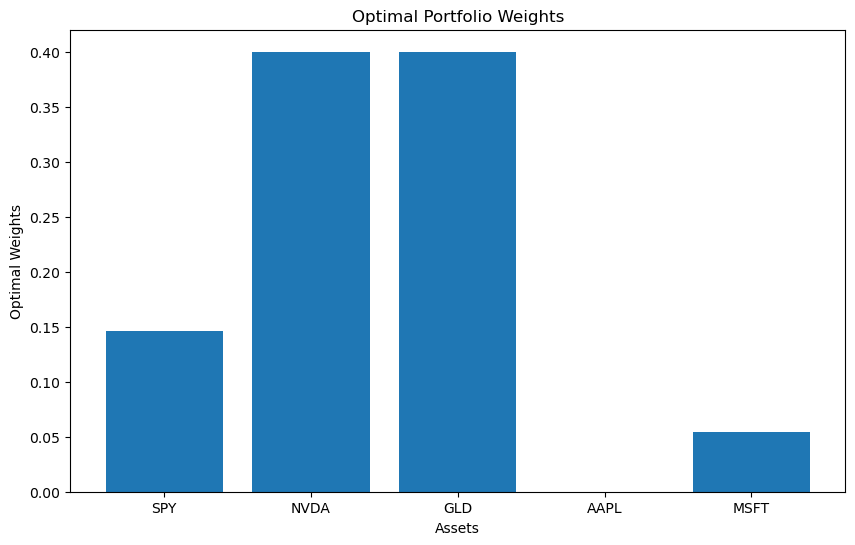

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()